In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# NAICS Embedding - Preliminary Plots
Plot embeddings from a couple sources, with different color schemes

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 

In [5]:
sg_plot.plot_defaults()

In [6]:
from sklearn.manifold import TSNE
from IPython.display import display, HTML

## Input Data
Create a table of NAICS info for plots

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [8]:
sba_loans.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'target', 'guaranteed_fract', 'new_business', 'urban_flag',
       'franchise_flag', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc',
       'NAICS_num', 'dset', 'dset_naics_holdout', 'menc_NAICS',
       'NS___Accommodation and Food Services', 'NS___Construction',
       'NS___Health Care and Social Assistance', 'NS___Manufacturing',
       'NS___Other Services (except Public Administration)',
       'NS___Professional, Scientific, and Technical Services',
       'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn',
       'cenc_NAICS', 'menc_grp_NAICS'],
      dtype='object')

In [9]:
sba_loans['NAICS'].astype('int')

index
0         451120
1         722410
2         621210
5         332721
7         811118
           ...  
897159    332431
897160    314912
897162    451120
897163    451130
897164    332321
Name: NAICS, Length: 688081, dtype: int64

In [10]:
sba_loans['NAICS']

index
0         451120
1         722410
2         621210
5         332721
7         811118
           ...  
897159    332431
897160    314912
897162    451120
897163    451130
897164    332321
Name: NAICS, Length: 688081, dtype: object

In [11]:
#label_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_label_info.parquet')).sort_index()

In [12]:
# Businesses per NAICS count
naics_train_info = pd.read_csv(Path(setup.temp_path).joinpath('60_REPORT_naics_train_counts.csv'),
                              dtype={'NAICS':'str', 'count':'int', 
                                     'naics_count_grp':'category'})

In [13]:
naics_train_info

,NAICS,count,naics_count_grp
0,722110,18218,"(500.0, inf]"
1,722211,12712,"(500.0, inf]"
2,811111,9264,"(500.0, inf]"
3,621210,8997,"(500.0, inf]"
4,624410,6432,"(500.0, inf]"
...,...,...,...
1150,926120,1,"(0.999, 50.0]"
1151,922150,1,"(0.999, 50.0]"
1152,315992,1,"(0.999, 50.0]"
1153,212399,1,"(0.999, 50.0]"


##### Create NAICS info table

In [14]:
naics_info_df = sba_loans[['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc',
                           'menc_NAICS', 'menc_grp_NAICS', 'NAICS_num', 'dset_naics_holdout']].drop_duplicates('NAICS') \
    .merge(naics_train_info, how='left', on='NAICS') \
    .rename(columns={'NAICS':'NAICS_orig'}) \
    .set_index('NAICS_orig')
naics_info_df['count'] = naics_info_df['count'].fillna(0)

## Functions for Plotting Embeddings

##### Retrieving embeddings, TSNE and NAICS join

In [15]:
def get_transform_embeddings(filename, naics_df = naics_info_df,
                            naics_col = 'NAICS_orig'):
    """ Read embeddings file, TSNE transform and merge in NAICS info"""
    embed_df = pd.read_parquet(filename)
    emb_cols = [c for c in embed_df.columns if c.startswith('emb')]
    trans = TSNE(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(embed_df[emb_cols]), 
                                   index=embed_df[naics_col])
    
    emb_transformed = emb_transformed.merge(naics_df, left_index=True, right_index = True)
    emb_transformed['sector_num'] = emb_transformed['NAICS_sector'].str[0:2].astype('int')

    return emb_transformed

##### Plot joined embeddings

In [16]:
def emb_plot(tsne_df, color_var = 'sector_num', alpha=0.7,
            figsize = (7, 7), cmap = 'jet',
            title_str = None,
            aspect = 'equal',
            outfile_folder = None,
            outfile_prefix = None,
            log_scale = False):

    fig, ax = plt.subplots(figsize=figsize)
    s = ax.scatter(
        tsne_df[0],
        tsne_df[1],
        c=tsne_df[color_var],
        cmap=cmap,
        alpha=alpha,
    )
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")
    ax.set_aspect(aspect)
    if title_str is not None:
        plt.title(f'{title_str}\nby {color_var}')
    else:
        plt.title(f'TSNE by {color_var}')
    
    if not log_scale:
        norm = colors.Normalize(tsne_df[color_var].min(), tsne_df[color_var].max())
    else:
        norm = colors.LogNorm(tsne_df[color_var].min() + 0.002, tsne_df[color_var].max())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if outfile_folder is not None:
        fig.savefig(oufile_folder.joinpath(outfile_prefix + '_' + color_var + '.png'),
                    bbox_inches='tight')
    
    return fig

## Plot Embeddings

In [17]:
embed_dict = {'nn embed': Path(setup.temp_path).joinpath('12_DATA_embeddings.parquet'),
              'nn embed remap': Path(setup.temp_path).joinpath('16_DATA_embeddings.parquet'),
              'dgi base': Path(setup.temp_path).joinpath('31_DATA_embeddings.parquet'),
              'dgi label': Path(setup.temp_path).joinpath('33_DATA_embeddings.parquet'),
              'dgi nn features': Path(setup.temp_path).joinpath('35_DATA_embeddings.parquet'),
              'dgi nn feat, label': Path(setup.temp_path).joinpath('37_DATA_embeddings.parquet')}

In [18]:
# Calculate all embeddings with appended info fields
embed_df = pd.concat([get_transform_embeddings(v) for v in embed_dict.values()],
                     keys = embed_dict.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'})

In [19]:
embed_df.head()

,model,0,1,NAICS_2,NAICS_sector,NAICS_sector_desc,menc_NAICS,menc_grp_NAICS,NAICS_num,dset_naics_holdout,count,naics_count_grp,sector_num
NAICS_orig,,,,,,,,,,,,,
722410,nn embed,-4.218862,-8.057798,72,72,Accommodation and Food Services,0.145905,0.145908,722410.0,0,2920.0,"(500.0, inf]",72
445299,nn embed,-48.731537,-0.078158,44,44-45,Retail Trade,0.203074,0.225793,445299.0,1,0.0,NaN,44
512110,nn embed,-48.063496,1.562371,51,51,Information,0.203074,0.257483,512110.0,1,0.0,NaN,51
541810,nn embed,-48.688244,-3.008406,54,54,"Professional, Scientific, and Technical Services",0.203074,0.192263,541810.0,1,0.0,NaN,54
421310,nn embed,34.800179,-11.304037,42,42,Wholesale Trade,0.059892,0.059889,421310.0,0,652.0,"(500.0, inf]",42


/var/folders/h9/4b0yxscx221gvjqy2cqp_kyh0000gn/T/ipykernel_63021/3972524536.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


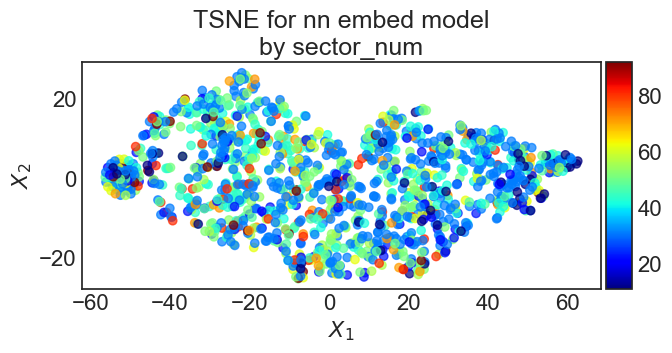

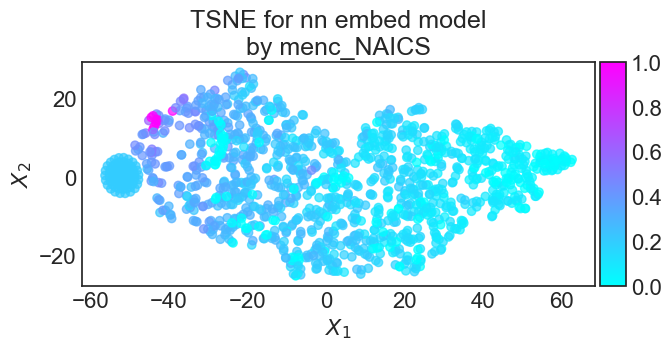

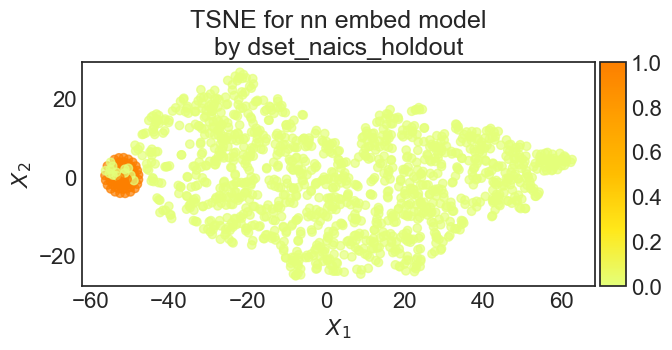

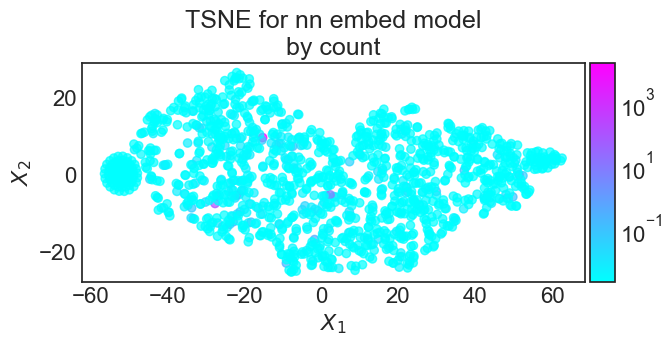

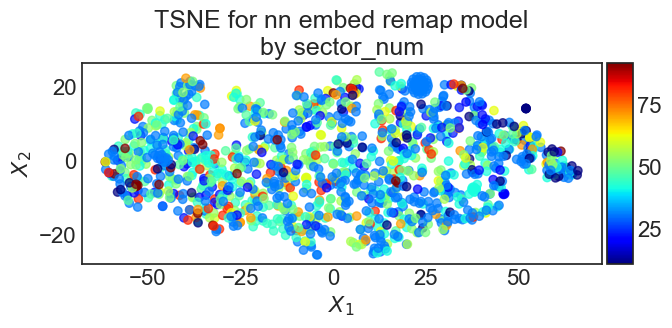

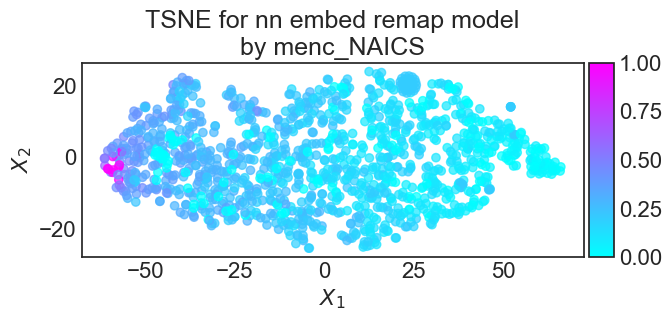

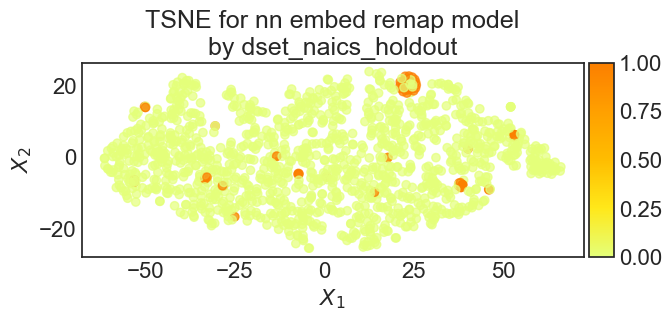

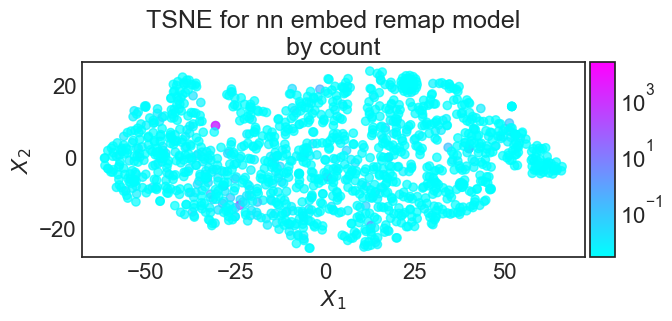

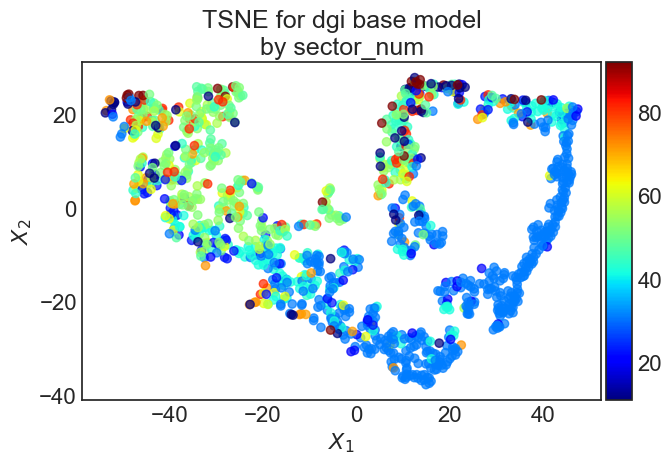

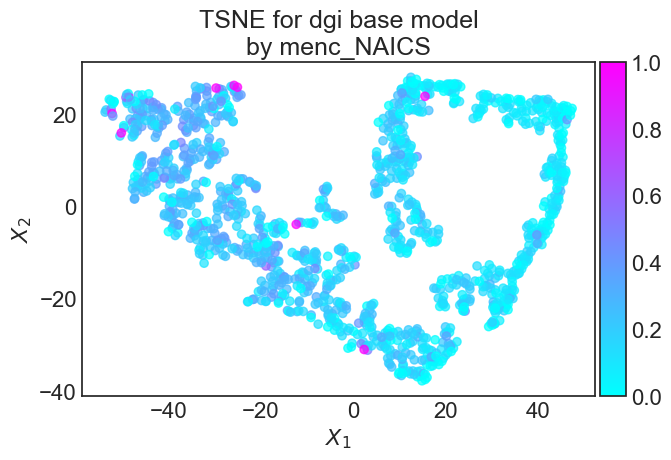

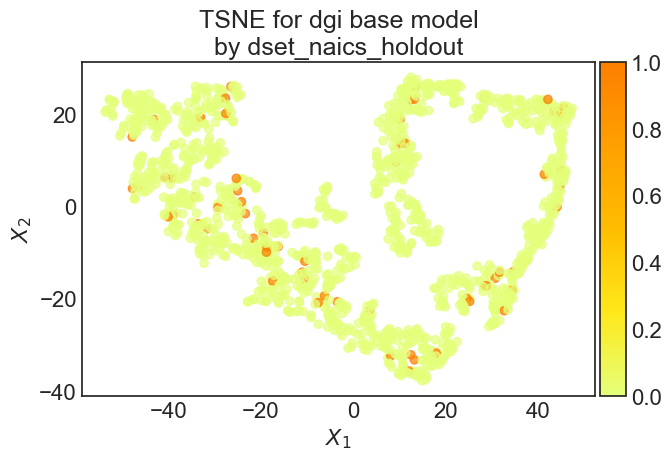

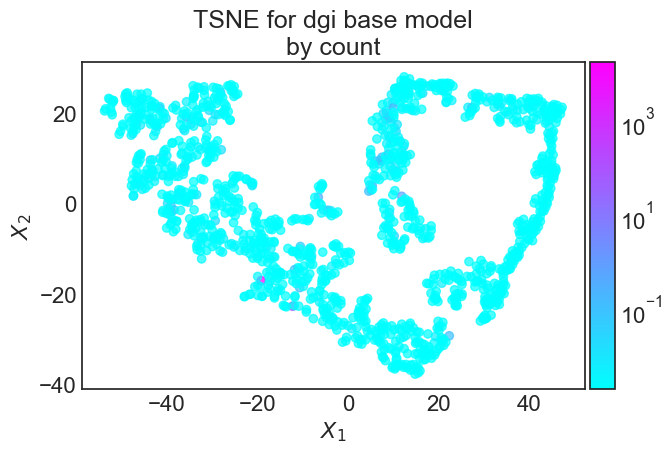

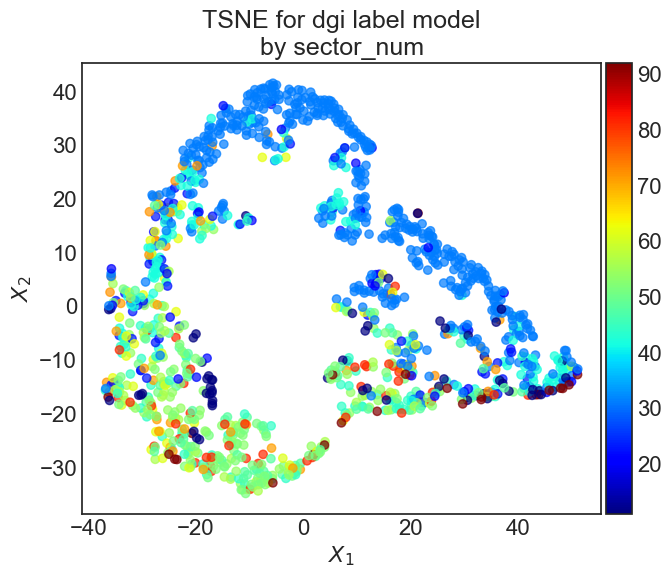

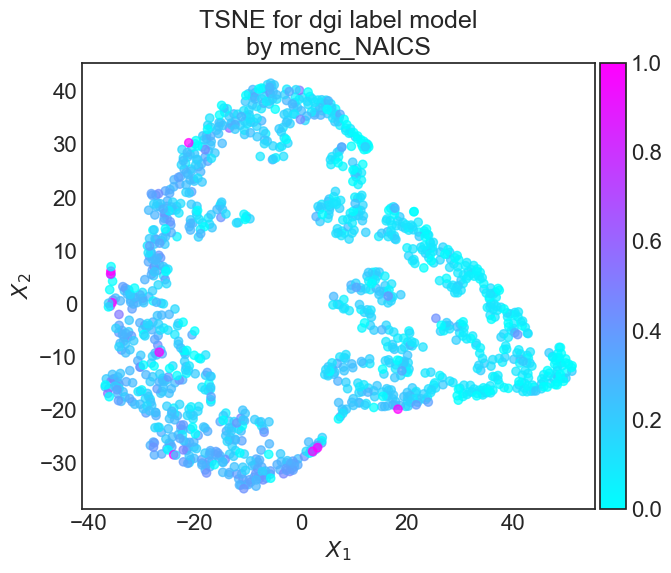

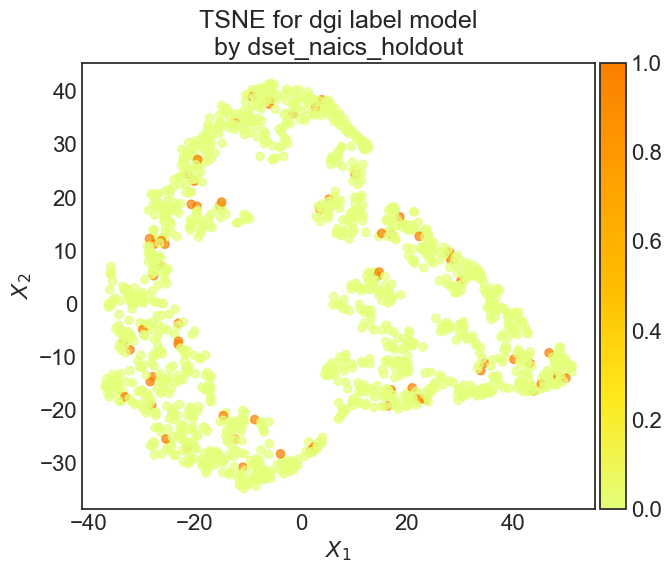

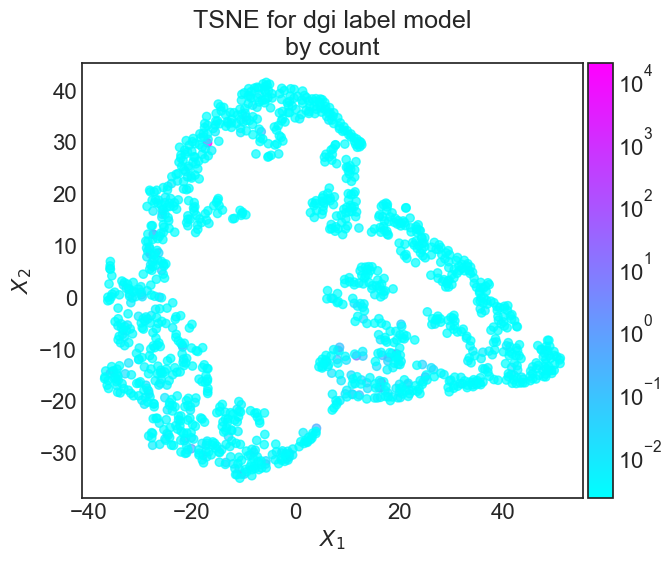

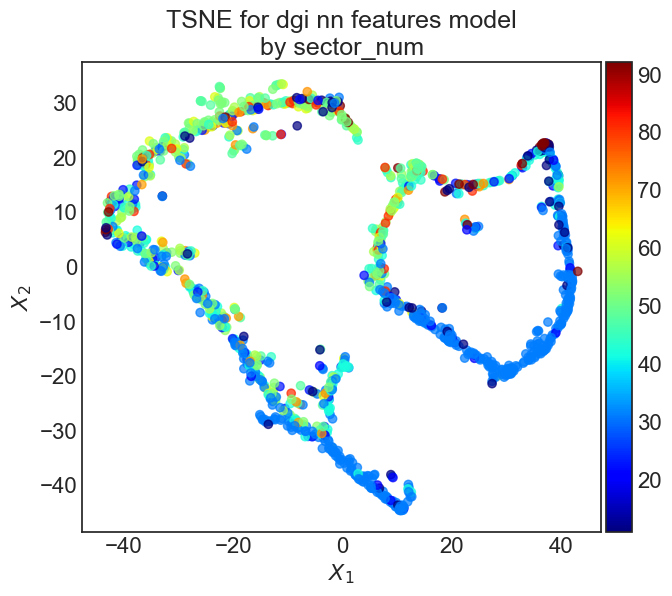

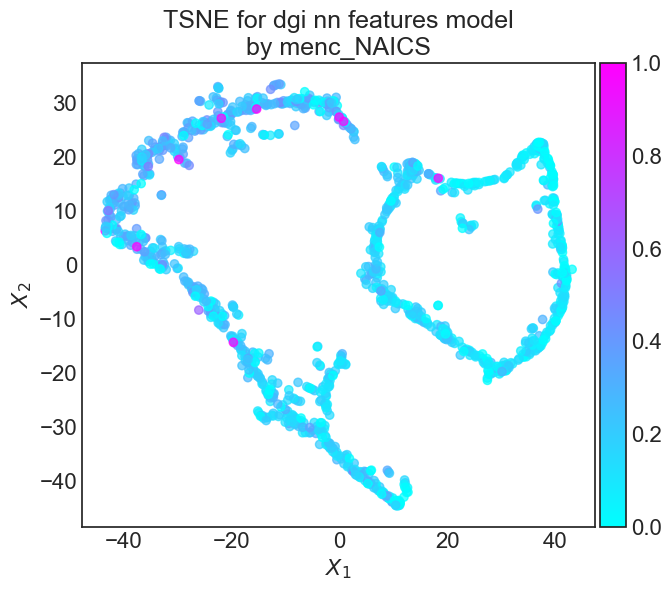

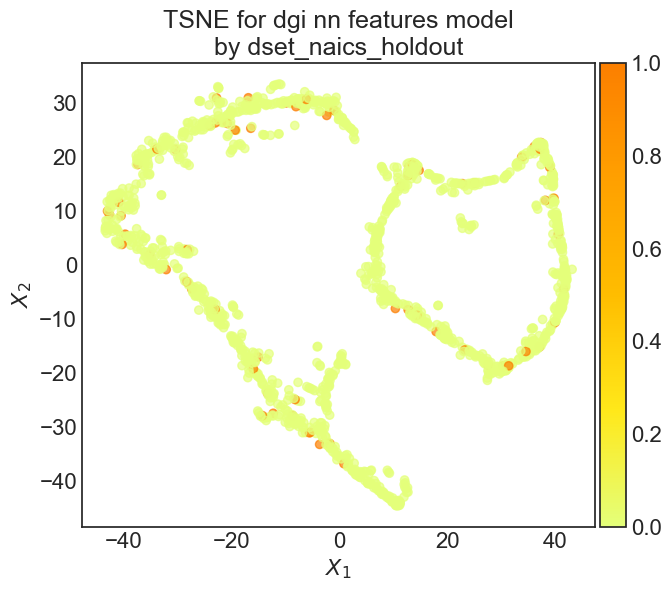

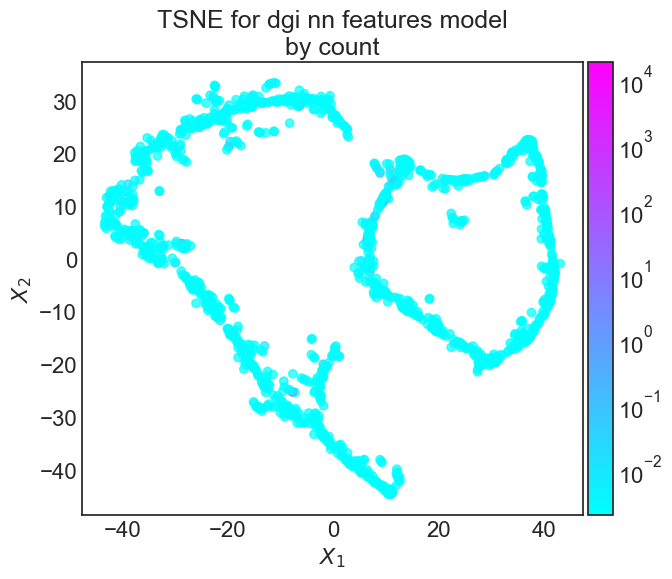

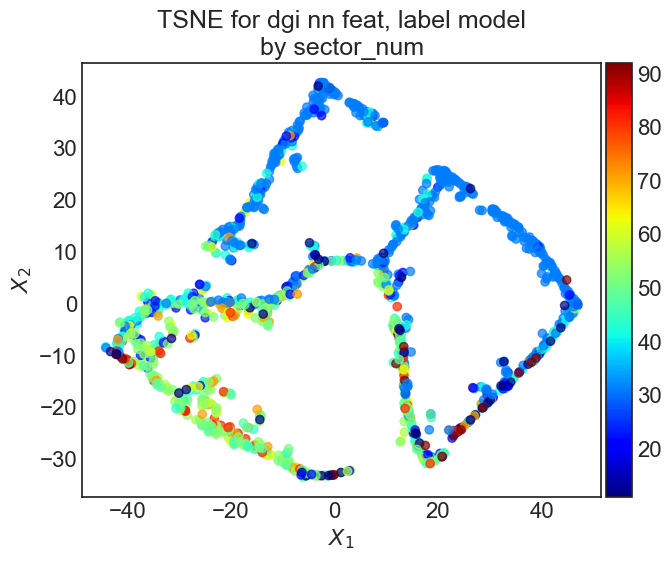

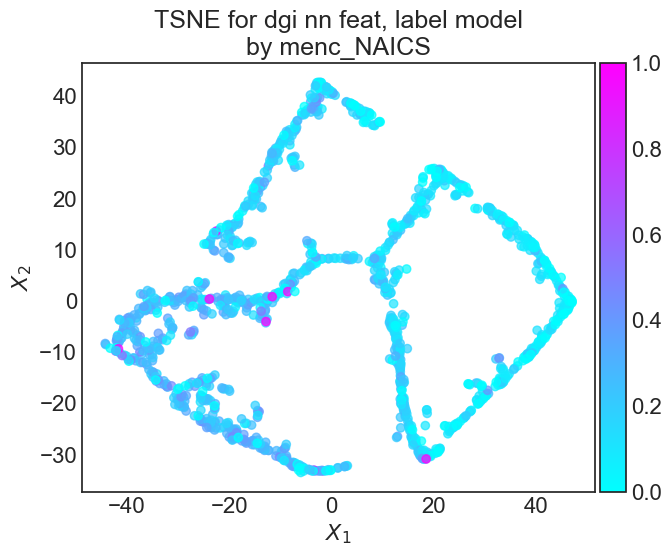

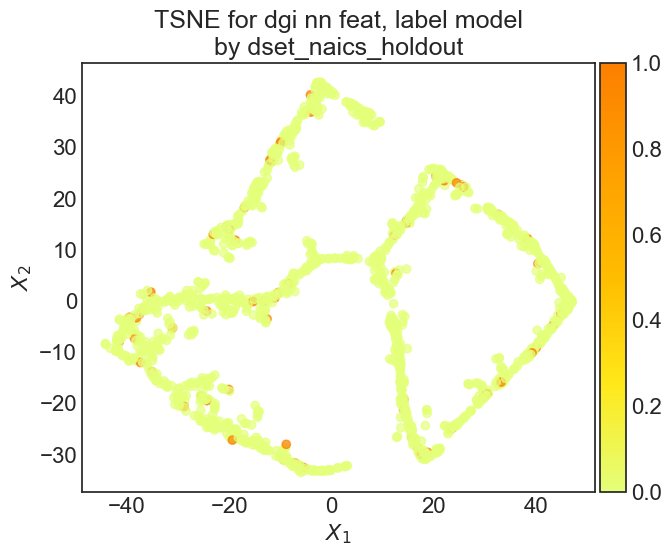

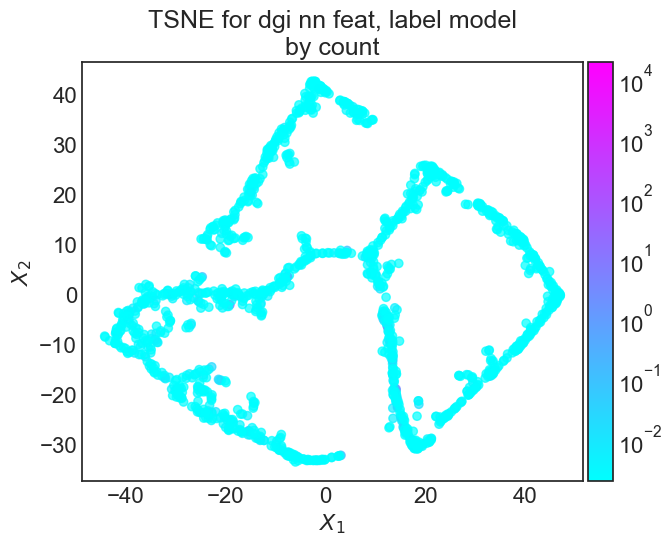

In [20]:
# Plot embeddings with several color schemes
for k, v in embed_dict.items():
    embed_trans_df = embed_df[embed_df['model'] == k]
    this_title = f'TSNE for {k} model'
    
    # NAICS sector
    fig = emb_plot(embed_trans_df, 'sector_num',
                  title_str = this_title, cmap = 'jet')
    fig
    
    # NAICS mean encoding
    fig = emb_plot(embed_trans_df, 'menc_NAICS',
                  title_str = this_title, cmap = 'cool')
    fig
    
    # Holdout status
    fig = emb_plot(embed_trans_df, 'dset_naics_holdout',
                  title_str = this_title, cmap = 'Wistia')
    fig
    
    # Code count
    fig = emb_plot(embed_trans_df, 'count',
                  title_str = this_title, cmap = 'cool', log_scale = True)
    fig

In [21]:
TO DO
- Consider rerunning 2X or just copy files
- More plots in 60
  - color coded scatter
  - count encoding deltas
- Add DGI model for remap embedding ???
- 61: Separate plots by type
- 60/61: add script 09

SyntaxError: invalid syntax (962753769.py, line 1)